In [ ]:
!pip install transformers datasets

In [ ]:
!pip install --upgrade transformers

In [ ]:
# Loading the dataset
import pandas as pd

df = pd.read_csv("malicious_phish.csv")
table = df['type'].value_counts().reset_index()
table.columns = ['Class', 'Count']
table


,Class,Count
0,benign,428103
1,defacement,96457
2,phishing,94111
3,malware,32520


In [ ]:
# Stratified split
from sklearn.model_selection import train_test_split

# Train
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df['type'],
    random_state=42
)

# Validation and Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['type'],
    random_state=42
)

# Length
print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

# Check if the data is Balanced
print(train_df['type'].value_counts())
print(val_df['type'].value_counts())
print(test_df['type'].value_counts())


Train: 455833
Val: 97679
Test: 97679
type
benign        299672
defacement     67520
phishing       65877
malware        22764
Name: count, dtype: int64
type
benign        64215
defacement    14469
phishing      14117
malware        4878
Name: count, dtype: int64
type
benign        64216
defacement    14468
phishing      14117
malware        4878
Name: count, dtype: int64


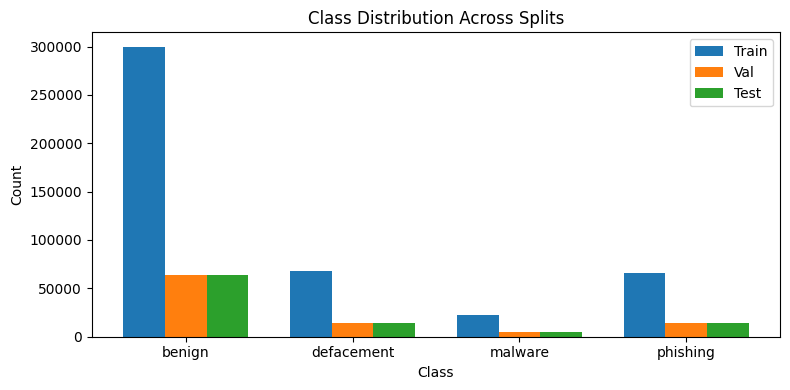

In [ ]:
# Visualization
import numpy as np
import matplotlib.pyplot as plt

classes = train_df['type'].value_counts().sort_index().index
train_counts = train_df['type'].value_counts().sort_index()
val_counts   = val_df['type'].value_counts().sort_index()
test_counts  = test_df['type'].value_counts().sort_index()

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(8,4))
plt.bar(x - width, train_counts, width, label='Train')
plt.bar(x,         val_counts,   width, label='Val')
plt.bar(x + width, test_counts,  width, label='Test')

plt.xticks(x, classes)
plt.title("Class Distribution Across Splits")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Create labels

label_map = {label: i for i, label in enumerate(df['type'].unique())}

train_df['label'] = train_df['type'].map(label_map)
val_df['label'] = val_df['type'].map(label_map)
test_df['label'] = test_df['type'].map(label_map)

label_map

{'phishing': 0, 'benign': 1, 'defacement': 2, 'malware': 3}

In [ ]:
# DistilBERT Tokenizer

from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Tokenization Function
def tokenize(batch):
    return tokenizer(
        batch['url'],
        padding="max_length",
        truncation=True,
        max_length=64
    )



# convert to HuggingFace Datasets

from datasets import Dataset

# Convert to HF datasets
train_ds = Dataset.from_pandas(train_df[['url', 'label']])
val_ds   = Dataset.from_pandas(val_df[['url', 'label']])
test_ds  = Dataset.from_pandas(test_df[['url', 'label']])

# Apply tokenizer
train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

# Set format for PyTorch
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map:   0%|          | 0/455833 [00:00<?, ? examples/s]

Map:   0%|          | 0/97679 [00:00<?, ? examples/s]

Map:   0%|          | 0/97679 [00:00<?, ? examples/s]

In [ ]:
# Load DistilBERT

from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to=[]          # disables wandb
)


# Trainer

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds
)


In [ ]:
# Training

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.065300,0.050454
2,0.035800,0.051283
3,0.011100,0.059515


TrainOutput(global_step=85470, training_loss=0.044253682005225156, metrics={'train_runtime': 8531.4036, 'train_samples_per_second': 160.29, 'train_steps_per_second': 10.018, 'total_flos': 2.2644437033304576e+16, 'train_loss': 0.044253682005225156, 'epoch': 3.0})

In [ ]:
# Evaluate

trainer.evaluate(test_ds)

{'eval_loss': 0.06156175211071968,
 'eval_runtime': 173.0321,
 'eval_samples_per_second': 564.514,
 'eval_steps_per_second': 35.282,
 'epoch': 3.0}

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Get predictions
predictions = trainer.predict(test_ds)
logits = predictions.predictions
labels = predictions.label_ids
preds = np.argmax(logits, axis=1)

# Accuracy
acc = accuracy_score(labels, preds)

# Precision, Recall, F1
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)
macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

# Build Table
classes = list(label_map.keys())
results_df = pd.DataFrame({
    "Class": classes,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
})

# Add macro results row
results_df.loc[len(results_df)] = ["Macro Avg", macro_p, macro_r, macro_f1]

# Round values
results_df = results_df.round(4)

print("Accuracy:", round(acc, 4))
print("\nClassification Metrics Table:")
print(results_df.to_string(index=False))


Accuracy: 0.9889

Classification Metrics Table:
     Class  Precision  Recall  F1-Score
  phishing     0.9641  0.9596    0.9619
    benign     0.9922  0.9944    0.9933
defacement     0.9974  0.9991    0.9982
   malware     0.9908  0.9705    0.9805
 Macro Avg     0.9861  0.9809    0.9835


In [ ]:
# Interactive tool for prediction of url

import torch

# Label map (same order you trained on)
id2label = {0: "phishing", 1: "benign", 2: "defacement", 3: "malware"}

# Prediction function
def predict_url(url):
    inputs = tokenizer(url, return_tensors="pt", truncation=True, padding=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    pred_id = torch.argmax(outputs.logits, dim=1).item()
    return id2label[pred_id]

# Interactive loop
print("Type a URL to classify it.")
print("Type 'exit' to stop.\n")

while True:
    url = input("Enter URL: ").strip()
    if url.lower() == "exit":
        print("Exiting.")
        break
    if not url:
        print("Empty input. Try again.\n")
        continue

    prediction = predict_url(url)
    print(f"Prediction: {prediction}\n")


Type a URL to classify it.
Type 'exit' to stop.

Enter URL: www.syfy.com/rewind/?p=50206
Prediction: phishing

Enter URL: account-verification-chase.com/login/secure
Prediction: benign

Enter URL: http://www.nptw103.com.tw/news.php?news_id=6
Prediction: defacement

Enter URL: soft-downloads247.com/windows/update/install.exe
Prediction: malware

Enter URL: exit 
Exiting.
